In this notebook, instead of using lmfit to fit the data, I will be using scipy.optimize and see if the fitting is improved or not.

In [19]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


# Goal

The goal of this notebook is to check the vertical center calculation using various 0deg files and various profiles

This notebooks takes the profile files produced by the [profile](https://neutronimaging.ornl.gov/tutorials/imaging-notebooks/profile/linear-profile/) notebook.

<img src='static/screenshot_of_profile_file.png' />


In [20]:
import os
import pandas as pd
import numpy as np
import glob

from ipywidgets import interactive
import ipywidgets as widgets

import pprint

from PIL import Image

from scipy.optimize import curve_fit, minimize_scalar

import matplotlib.pyplot as plt
%matplotlib inline

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*base_folder = "/SNS/VENUS/IPTS-31716/shared/NC_images/2023-06-12"*


# User input 

In [21]:
top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"
# top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"

### set up base folder 

In [22]:
base_folder = top_folder + "/profiles/"
assert os.path.exists(base_folder)  # making sure the base folder exists

## working with various profiles and 3 different 0deg images

In [23]:
list_profile_files = glob.glob(os.path.join(base_folder, '300deg_near_ideal_x_and_y_center') + '/*.txt')
assert len(list_profile_files) > 0
print(f"{list_profile_files =}")

list_profile_files =['/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/300deg_near_ideal_x_and_y_center/horizontal_profile.txt', '/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/300deg_near_ideal_x_and_y_center/vertical_profile.txt']


## load profiles 

In [24]:
data_dict = {}

for _file in list_profile_files:
    
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=8)
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    profile = np.asarray(pd_data.loc[:, list_names_of_columns[1]])
    
    _dict = {'xaxis': xaxis,
             'profile': profile,
             }
    
    data_dict[base_file_name] = _dict

In [25]:
# pprint.pprint(data_dict)

# fitting horizontal and vertical profile

### using scipy.optimize 

In [26]:
data_dict.keys()

dict_keys(['horizontal_profile.txt', 'vertical_profile.txt'])

In [27]:
# def gauss_function(x, h, a, x0, sigma):
#     return h + a*np.exp(-(x-x0)**2/(2*sigma**2))

# def gauss(x, a, b, c):
#     return c + a*np.exp(-1*b*x**2)

def poly3d(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3

# def fit3(x, a, b, c):
#     return a*x**3 + b*x**2*c

In [28]:
data_dict.keys()

dict_keys(['horizontal_profile.txt', 'vertical_profile.txt'])

In [29]:
profile_fitted_dict = {}
for _key in data_dict.keys():
    
    xaxis = data_dict[_key]['xaxis']
    yaxis = data_dict[_key]['profile']
    
    para, cova = curve_fit(poly3d, xaxis, yaxis)
    print(f"{_key =}")
    print(*para)
    
    fm = lambda x: -poly3d(x, *para)
    r = minimize_scalar(fm, bounds=(1000, 6000))
    x_max = r['x']
    y_max = poly3d(r['x'], *para)
    
#     fm_error = lambda x: -poly3d(x, *perr)
#     r_error = minimize_scalar(fm_error, bounds=(1000, 6000))
#     x_error_max = r_error['x']
    
    
    profile_fitted_dict[_key] = {'x_center': x_max,
#                                  'x_center_error': x_error_max,
                                 'y_center': y_max,
#                                  'error': perr,
                                 'parameters': para}

_key ='horizontal_profile.txt'
-6073.349086405055 11.294109704735131 -0.001548666189159754 4.250690730787936e-08
_key ='vertical_profile.txt'
11388.821456156964 4.553313677804588 -0.000998857055565279 3.5546803502070283e-08


In [30]:
profile_fitted_dict

{'horizontal_profile.txt': {'x_center': 4468.474019251871,
  'y_center': 17264.06771529015,
  'parameters': array([-6.07334909e+03,  1.12941097e+01, -1.54866619e-03,  4.25069073e-08])},
 'vertical_profile.txt': {'x_center': 2655.7640092900997,
  'y_center': 17102.165496312933,
  'parameters': array([ 1.13888215e+04,  4.55331368e+00, -9.98857056e-04,  3.55468035e-08])}}

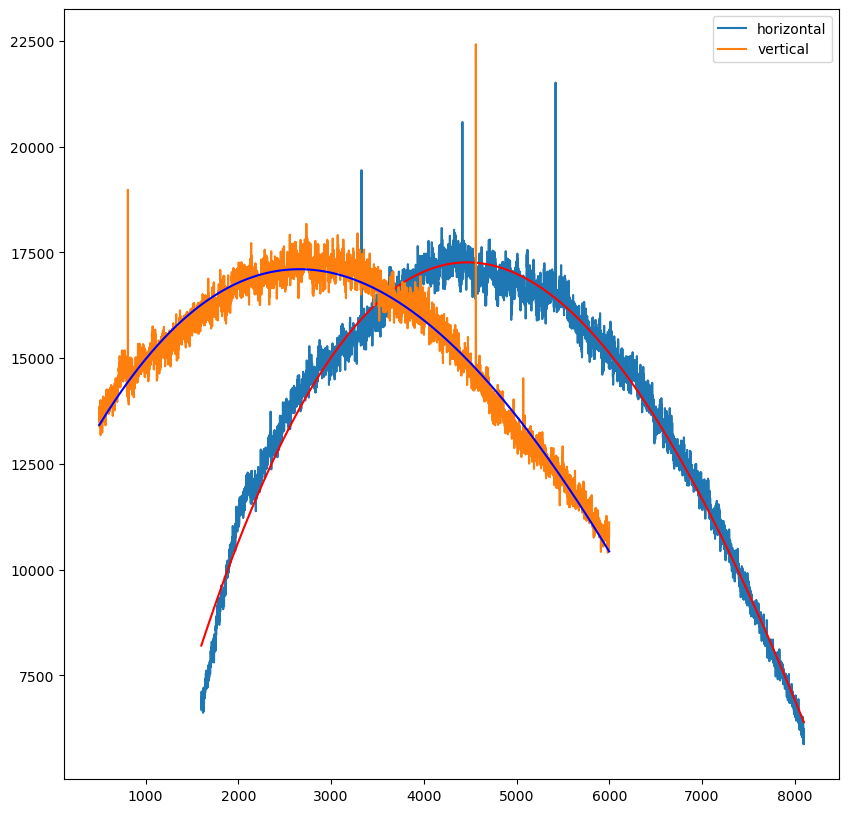

In [31]:
plt.figure(num='0', figsize=(10, 10))
plt.plot(data_dict['horizontal_profile.txt']['xaxis'], data_dict['horizontal_profile.txt']['profile'], label='horizontal')
plt.plot(data_dict['horizontal_profile.txt']['xaxis'], 
         poly3d(data_dict['horizontal_profile.txt']['xaxis'], 
                *profile_fitted_dict['horizontal_profile.txt']['parameters']), 'r')
plt.plot(data_dict['vertical_profile.txt']['xaxis'], data_dict['vertical_profile.txt']['profile'], label='vertical')
plt.plot(data_dict['vertical_profile.txt']['xaxis'], 
         poly3d(data_dict['vertical_profile.txt']['xaxis'], 
               *profile_fitted_dict['vertical_profile.txt']['parameters']), 'b')
plt.legend()


In [32]:
profile_fitted_dict

{'horizontal_profile.txt': {'x_center': 4468.474019251871,
  'y_center': 17264.06771529015,
  'parameters': array([-6.07334909e+03,  1.12941097e+01, -1.54866619e-03,  4.25069073e-08])},
 'vertical_profile.txt': {'x_center': 2655.7640092900997,
  'y_center': 17102.165496312933,
  'parameters': array([ 1.13888215e+04,  4.55331368e+00, -9.98857056e-04,  3.55468035e-08])}}

## Let's plot the center of the beam found over the image 

In [33]:
base_folder = top_folder + "/median_data/"
image_filename = os.path.join(base_folder, '300deg_nbr1_30s_frames_OB.tif')
assert os.path.exists(image_filename)

In [34]:
image = np.asarray(Image.open(image_filename))

center_x = profile_fitted_dict['horizontal_profile.txt']['x_center']
# center_x_error = profile_fitted_dict['horizontal_profile.txt']['x_center_error']

center_y = profile_fitted_dict['vertical_profile.txt']['x_center']
# center_y_error = profile_fitted_dict['vertical_profile.txt']['x_center_error']



Text(4468.474019251871, 2655.7640092900997, '   x:4468, \n   y:2655')

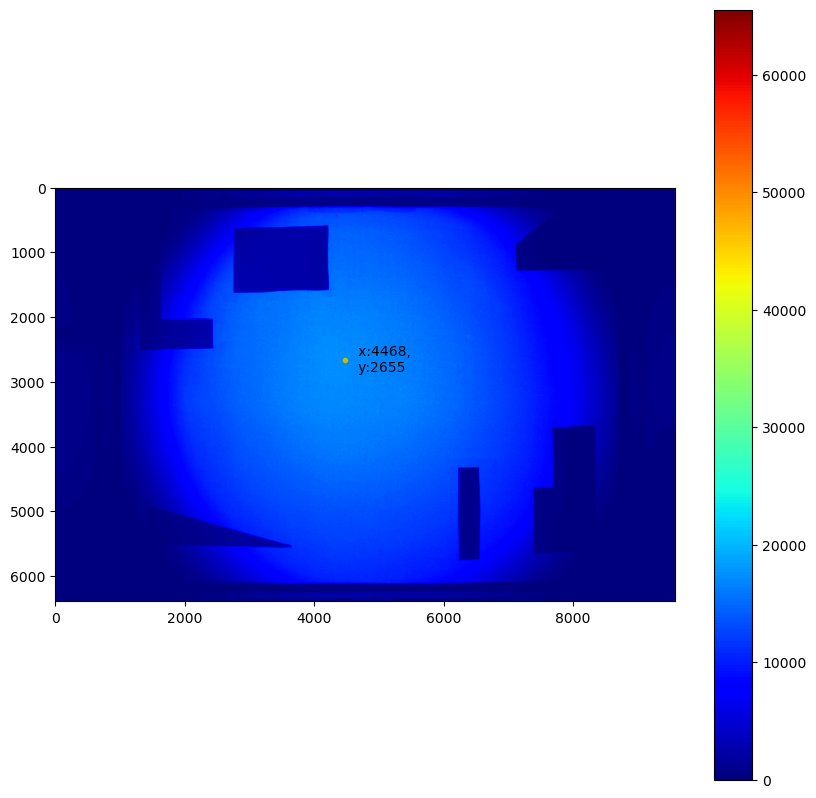

In [35]:
text_offset = 30

plt.figure(0, figsize=(10, 10))
plt.imshow(image, cmap='jet')
#plt.errorbar(center_x, center_y, xerr=center_x_error, yerr=center_y_error, color='yellow', ecolor='black', fmt='.')
plt.plot(center_x, center_y, '.y')
plt.colorbar()
plt.text(center_x, center_y,
         f"   x:{int(center_x)}, \n   y:{int(center_y)}",
                 horizontalalignment='left',
         verticalalignment='center'
)

## Evaluation of fitting 

In [47]:
sum_diff_dict = {}
for _key in data_dict.keys():
    xaxis = data_dict[_key]['xaxis']
    yaxis = data_dict[_key]['profile']
    yaxis_fitted = poly3d(data_dict[_key]['xaxis'], *profile_fitted_dict[_key]['parameters'])
    
    sum_diff = 0
    for _y, _y_fitted in zip(yaxis, yaxis_fitted):
        sum_diff += abs(_y - _y_fitted)
    
    sum_diff_dict[_key] = sum_diff
    

In [48]:
sum_diff_dict

{'horizontal_profile.txt': 1799053.2795939578,
 'vertical_profile.txt': 1323663.152022368}